In [1]:
if (!require("igraph")) install.packages("igraph")
library ("igraph")
if (!require("clevr")) install.packages("clevr")
library ("clevr")

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: clevr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘clevr’”
also installing the dependencies ‘Rcpp’, ‘BH’





The downloaded binary packages are in
	/var/folders/m6/4mgxnhd5575fll1p8n3_wcjc0000gn/T//RtmpEHkWWY/downloaded_packages


In [277]:
# Reading the csv files
path = "finance_data/data/"
out.file<-""
file.names <- dir(path, pattern =".csv")
m <- matrix(, nrow = 0, ncol = 765)
sectors.table <- read.table("finance_data/Name_sector.csv",header=TRUE, sep=",", stringsAsFactors=TRUE)
sectors = c()
sectors.names <- c()
for(i in 1:length(file.names)){
    file <- read.table(paste("finance_data/data/",file.names[i],sep = ""),header=TRUE, sep=",", stringsAsFactors=FALSE)
    if(length(file$Close)==765){
        m <- rbind(m, matrix(file$Close, nrow=1, ncol=765))
        mystr <- substr(file.names[i], 1, nchar(file.names[i])-4)
        sector <- sectors.table$Sector[which(sectors.table$Symbol == mystr)]
        sectors.names = c(sectors.names, toString(sector))
    }
}

In [278]:
# Printing the sector details
com_num = length(sectors.names)
data_num = ncol(m)
sector.set<-as.factor(sectors.names)
sectors.index<-as.numeric(sector.set)
num_sector <- length(unique(sectors.index))
table(sector.set)

sector.set
    Consumer Discretionary           Consumer Staples 
                        84                         36 
                    Energy                 Financials 
                        34                         63 
               Health Care                Industrials 
                        60                         64 
    Information Technology                  Materials 
                        66                         24 
               Real Estate Telecommunication Services 
                        31                          4 
                 Utilities 
                        28 

QUESTION 1: What are upper and lower bounds on $ρ_{ij}$? Provide a justification for using log- normalized return ($r_i(t)$) instead of regular return ($q_i(t)$).

$\rho_{ij}=\frac{\langle r_i(t) r_j(t) \rangle - \langle r_i(t) \rangle \langle r_j(t) \rangle}{\sqrt{(\langle r_i(t)^2 \rangle - \langle r_i(t) \rangle^2)(\langle r_j(t)^2 \rangle - \langle r_j(t) \rangle^2)}}$  
Let $\langle x(t) \rangle = \frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} x(t)$.  
Then  
$\rho_{ij}=\frac{\frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_i(t)r_j(t)- \frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_i(t) \frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_j(t)}{\sqrt{\big( \frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_i(t)^2-\frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_i(t)\frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_i(t)\big)\big(\frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_j(t)^2-\frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_j(t)\frac{1}{t_{max}}\sum\limits_{t=1}^{t_{max}} r_j(t)\big)}}$  
  
Simplify the notation:  
  
$\rho_{ij}=\frac{\frac{1}{t}\sum r_ir_j- \frac{1}{t}\sum r_i \frac{1}{t}\sum r_j}{\sqrt{\big( \frac{1}{t}\sum r_i^2-\frac{1}{t}\sum r_i\frac{1}{t}\sum r_i\big)\big(\frac{1}{t}\sum r_j^2-\frac{1}{t}\sum r_j\frac{1}{t}\sum r_j\big)}}$
$=\frac{\frac{1}{t}\sum r_ir_j- \big(\frac{1}{t}\big)^2\sum r_i \sum r_j}{\sqrt{\big( \frac{1}{t}\sum r_i^2-\big(\frac{1}{t}\big)^2\sum r_i\sum r_i\big)\big(\frac{1}{t}\sum r_j^2-\big(\frac{1}{t}\big)^2\sum r_j\sum r_j\big)}}$  
  
Case 1, $r_i = r_j$:  
$\rho_{ij}=\frac{\frac{1}{t}\sum r^2- \big(\frac{1}{t}\big)^2\sum r \sum r}{\sqrt{\big( \frac{1}{t}\sum r^2-\big(\frac{1}{t}\big)^2\sum r\sum r\big)\big(\frac{1}{t}\sum r^2-\big(\frac{1}{t}\big)^2\sum r\sum r\big)}}$ 
$=\frac{\frac{1}{t}\sum r^2- \big(\frac{1}{t}\big)^2\sum r \sum r}{\frac{1}{t}\sum r^2- \big(\frac{1}{t}\big)^2\sum r \sum r}=1$  
  
Case 2, $r_i = -r_j$:  
$\rho_{ij}=\frac{\frac{1}{t}\big(-\sum r^2\big)- \big(\frac{1}{t}\big)^2\big(-\sum r \sum r\big)}{\sqrt{\big( \frac{1}{t}\sum r^2-\big(\frac{1}{t}\big)^2\sum r\sum r\big)\big(\frac{1}{t}\sum r^2-\big(\frac{1}{t}\big)^2\sum r\sum r\big)}}$
$=\frac{-\big(\frac{1}{t}\sum r^2- \big(\frac{1}{t}\big)^2\sum r \sum r\big)}{\frac{1}{t}\sum r^2- \big(\frac{1}{t}\big)^2\sum r \sum r}=-1$  
  
Thus, the lower bound is -1 and the upper bound is 1.  

One reason why $r_i(t)$ may be used instead of $q_i(t)$ could be that if $p_i(t)$ were to remain constant throughout the time interval, then $q_i(t) = \langle q_i(t)^2\rangle=\langle q_i(t)\rangle^2=0$. This would cause one of the factors in the denominator of $\rho_{ij}$ to be 0 which would make $\rho_{ij}$ undefined.  
Another reason why $r_i(t)$ may be used is that if $q_i(t)$ is trending in an exponential manner, then using the log form makes it linear. This is a simplified representation which is often preferable. This transformation also makes it so that outliers are not as far away from the other data points which is often advantageous for applications like machine learning.

QUESTION 2: Plot a histogram showing the un-normalized distribution of edge weights.

In [280]:
cal_cor<-function(comp_date){
log_val <- matrix(nrow=nrow(comp_date), ncol= ncol(comp_date)-1)
for(j in 1:nrow(comp_date)){
        log_val[j,] = diff(log(comp_date[j, ]))}
log_avg <- rowMeans(log_val)
temp <- cor(t(log_val))
return(temp)
    }

In [281]:
temp <- cal_cor(m)
d <- sqrt(2 * (1 - temp))
g<-graph_from_adjacency_matrix(d, mode ="upper", weighted = TRUE, diag = TRUE,
  add.colnames = NULL, add.rownames = NA)
fname <- matrix(d)
save(fname, file = "distance.RData")

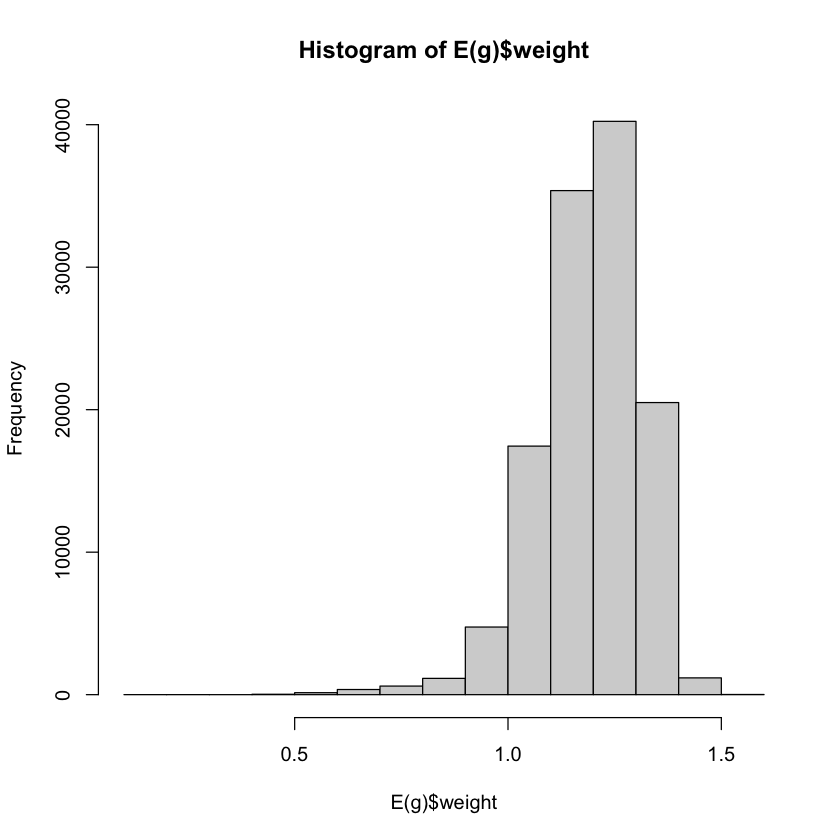

In [282]:
# Plotting the un-normalized distribution of edge weights
hist(E(g)$weight)

QUESTION 3: Extract the MST of the correlation graph. Each stock can be categorized into a sector, which can be found in Name sector.csv file. Plot the MST and color-code the nodes based on sectors. Do you see any pattern in the MST? The structures that you find in MST are called Vine clusters. Provide a detailed explanation about the pattern you observe.

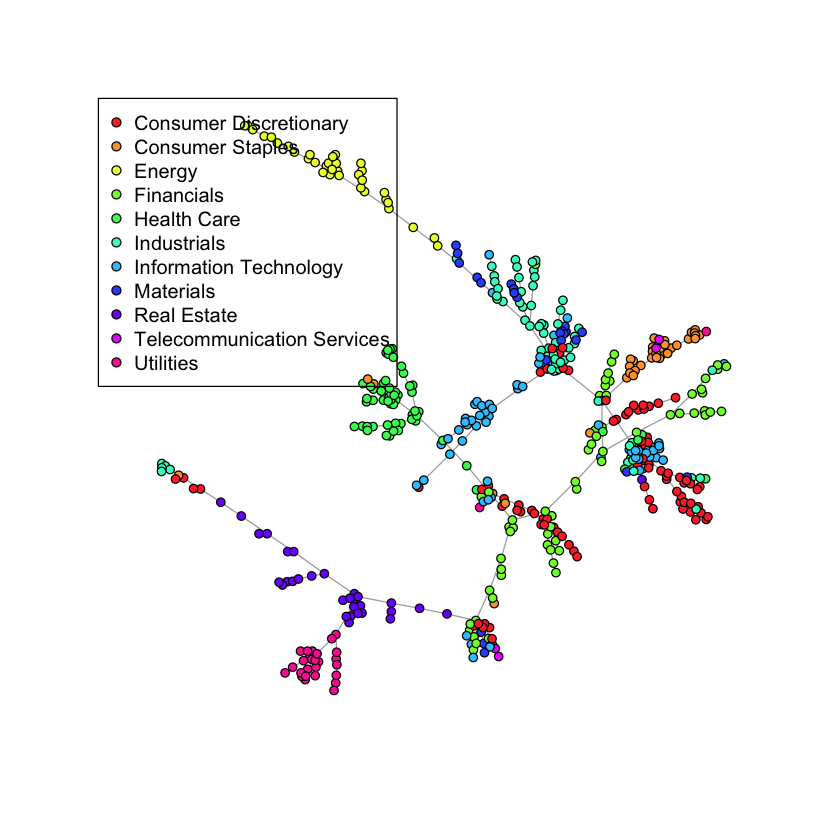

In [9]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_g <- mst(g, algorithm = 'prim')
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_g, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

A pattern that can be seen is that the nodes with the same sector coloring tend to be grouped together in the vine clusters of the tree.

QUESTION 4: Run a community detection algorithm (for example walktrap) on the MST ob- tained above. Plot the communities formed. Compute the homogeneity and completeness of the clustering. (you can use the ’clevr’ library in r to compute homogeneity and completeness).

[1] 33

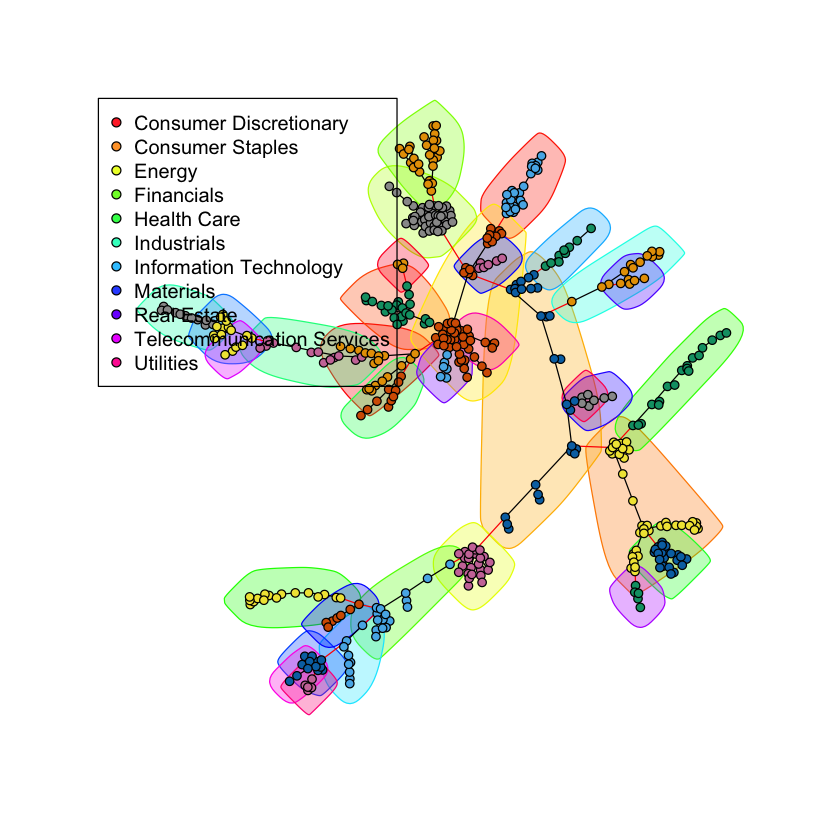

In [11]:
# Clustering of correlation graph
wc_daily <- walktrap.community(mst_g, weights= E(mst_g)$weights, modularity = TRUE) 
length(wc_daily)
plot(wc_daily, mst_g, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [12]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)
pred <- c(wc_daily$membership)
homogeneity(true, pred)
completeness(true,pred)

[1] 0.6826446

[1] 0.4792845

QUESTION 5: Report the value of α for the two cases and provide an interpretation for
the difference.

In [283]:
card_V = length(V(mst_g))
sum1 = 0
sum2 = 0
for(v in V(mst_g)){
    card_N = length(neighbors(mst_g,v))
    v_sect = sectors.index[v]
    card_Q = 0
    for(n in neighbors(mst_g, v)){
        if(sectors.index[n] == v_sect){
            card_Q = card_Q + 1
        }
    }
    card_S = length(sectors.index[sectors.index==v_sect])
    p1 = card_Q / card_N
    p2 = card_S / card_V
    sum1 = sum1 + p1
    sum2 = sum2 + p2
}
alpha1 = sum1 / card_V
alpha2 = sum2 / card_V
print("Alpha with first definition of P:")
print(alpha1)
print("Alpha with second definition of P:")
print(alpha2)

[1] "Alpha with first definition of P:"
[1] 0.8289301
[1] "Alpha with second definition of P:"
[1] 0.1141881


For the first case, P is the fraction of neighbors that are in the same sector out of all the neighbors. For the second case, P is the fraction of all nodes that are in the same sector out of all nodes. The second case is a much smaller fraction with the largest number of nodes in a given sector being 84 which is less than a fifth of all nodes. Since the nodes are well-clustered based on sector, the first case has a relatively high value.

QUESTION 6: Repeat questions 2,3,4,5 on the WEEKLY data.

In [284]:
file <- read.table(paste("finance_data/data/",file.names[1],sep = ""),header=TRUE, sep=",", stringsAsFactors=FALSE)
Date_data<- file$Date
weekdays_data <-weekdays(as.Date(Date_data))

weekly_m_m <- m[,which("Monday" == weekdays_data)]
week_m_cor <- cal_cor(weekly_m_m)
week_m_d <- sqrt(2 * (1 - week_m_cor))


week_m_g<-graph_from_adjacency_matrix(week_m_d, mode ="upper", weighted = TRUE, diag = TRUE,
  add.colnames = NULL, add.rownames = NA)

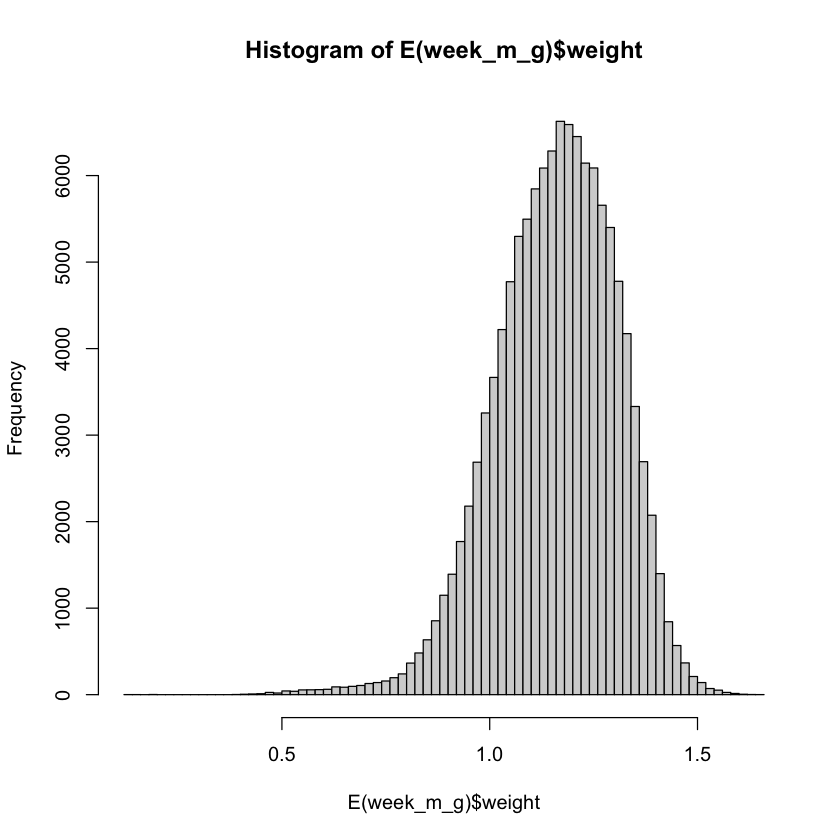

In [285]:
# Plotting the un-normalized distribution of edge weights
hist(E(week_m_g)$weight,breaks = 100)

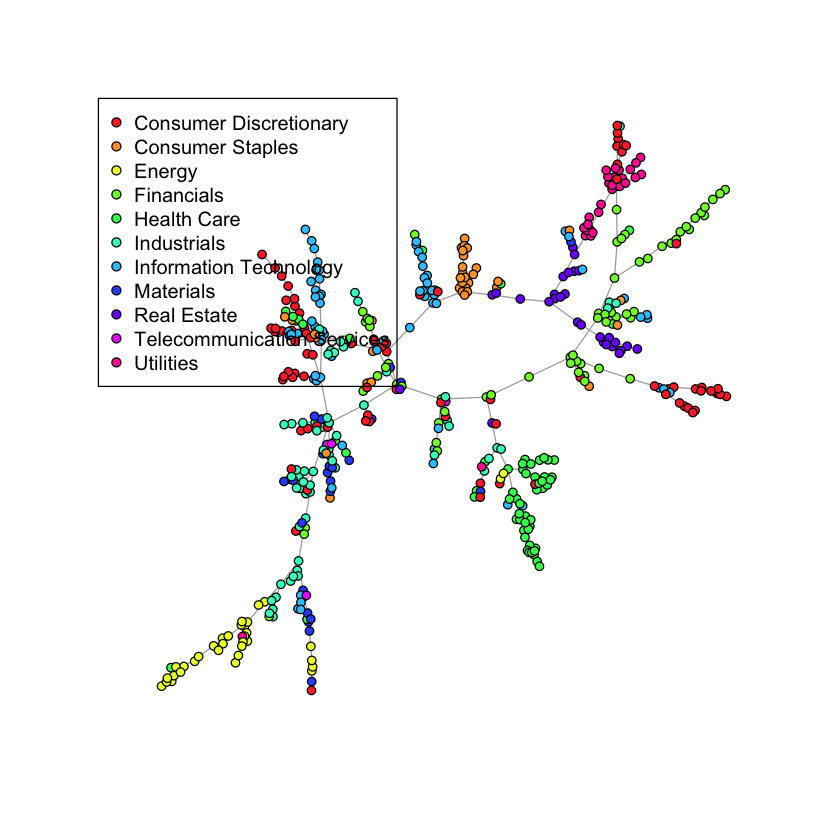

In [286]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_gw <- mst(week_m_g)
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_gw, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

[1] 42

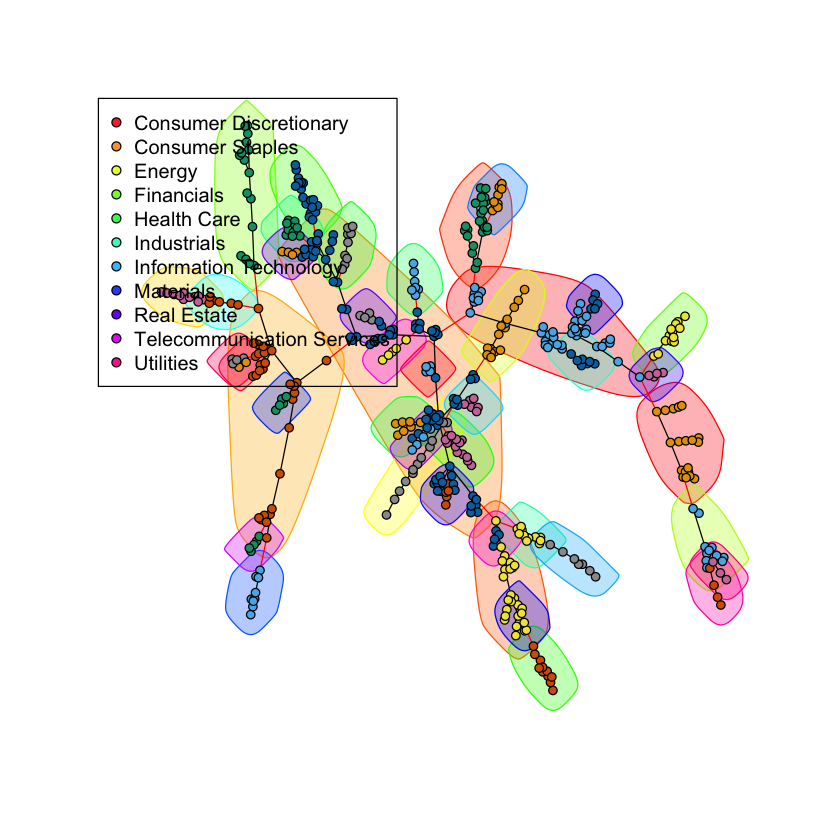

In [287]:
# Clustering of correlation graph
wc_weekly <- walktrap.community(mst_gw, weights= E(mst_gw)$weights, modularity = TRUE) 
length(wc_weekly)
plot(wc_weekly, mst_gw, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [288]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)
pred <- c(wc_weekly$membership)
homogeneity(true, pred)
completeness(true,pred)

[1] 0.582007

[1] 0.3907714

In [ ]:
card_V = length(V(mst_gw))
sum1 = 0
sum2 = 0
for(v in V(mst_gw)){
    card_N = length(neighbors(mst_gw,v))
    v_sect = sectors.index[v]
    card_Q = 0
    for(n in neighbors(mst_gw, v)){
        if(sectors.index[n] == v_sect){
            card_Q = card_Q + 1
        }
    }
    card_S = length(sectors.index[sectors.index==v_sect])
    p1 = card_Q / card_N
    p2 = card_S / card_V
    sum1 = sum1 + p1
    sum2 = sum2 + p2
}
alpha1 = sum1 / card_V
alpha2 = sum2 / card_V
print("Alpha with first definition of P:")
print(alpha1)
print("Alpha with second definition of P:")
print(alpha2)

[1] "Alpha with first definition of P:"
[1] 0.7429696
[1] "Alpha with second definition of P:"
[1] 0.1141881


QUESTION 7: Repeat questions 2,3,4,5 on the MONTHLY data.

In [291]:
dates_num <- format(as.Date(Date_data,format="%Y-%m-%d"), format = "%d")
monthly_15_m <- m[,which("15" == dates_num)]
monthly_15_cor <- cal_cor(monthly_15_m )
monthly_15_d <- sqrt(2 * (1 - monthly_15_cor))
month_15_g<-graph_from_adjacency_matrix(monthly_15_d, mode ="upper", weighted = TRUE, diag = TRUE,
  add.colnames = NULL, add.rownames = NA)

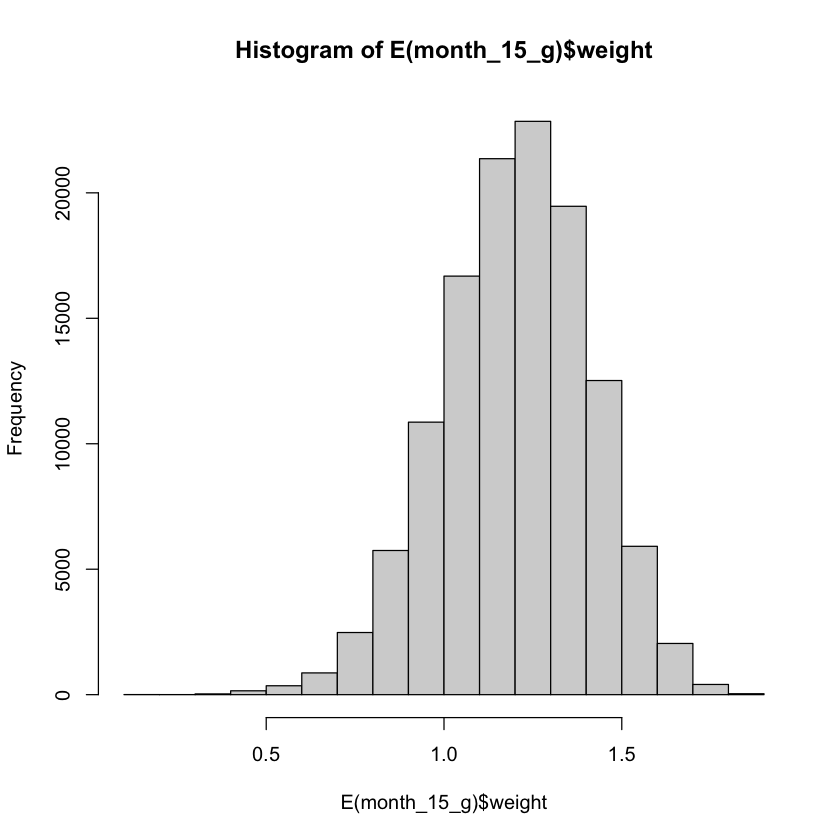

In [292]:
# Plotting the un-normalized distribution of edge weights
hist(E(month_15_g)$weight)

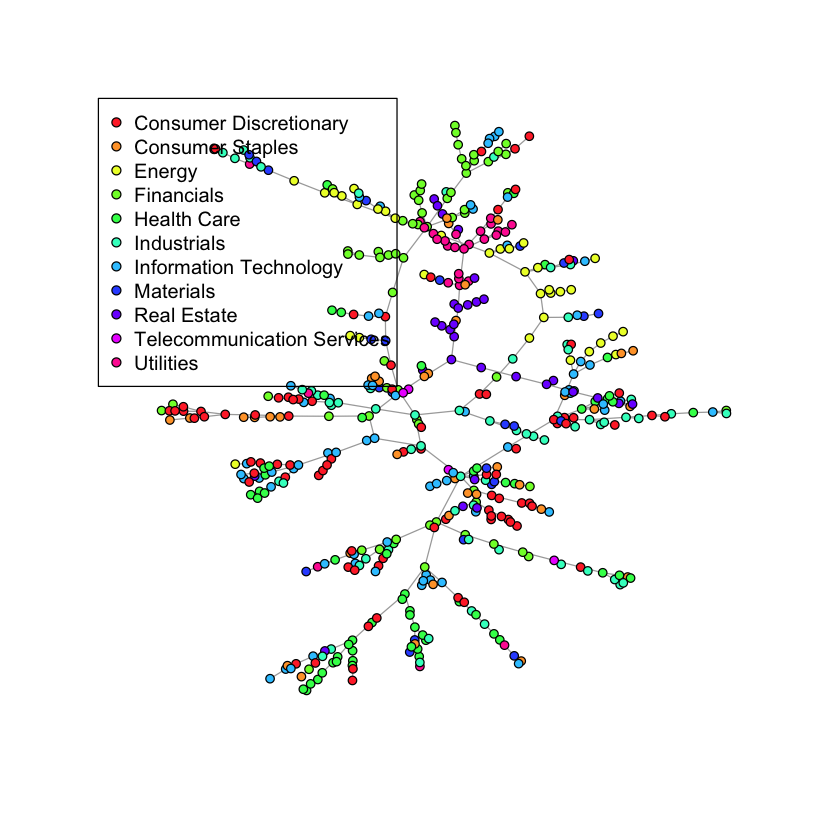

In [293]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_gm <- mst(month_15_g)
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_gm, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

[1] 74

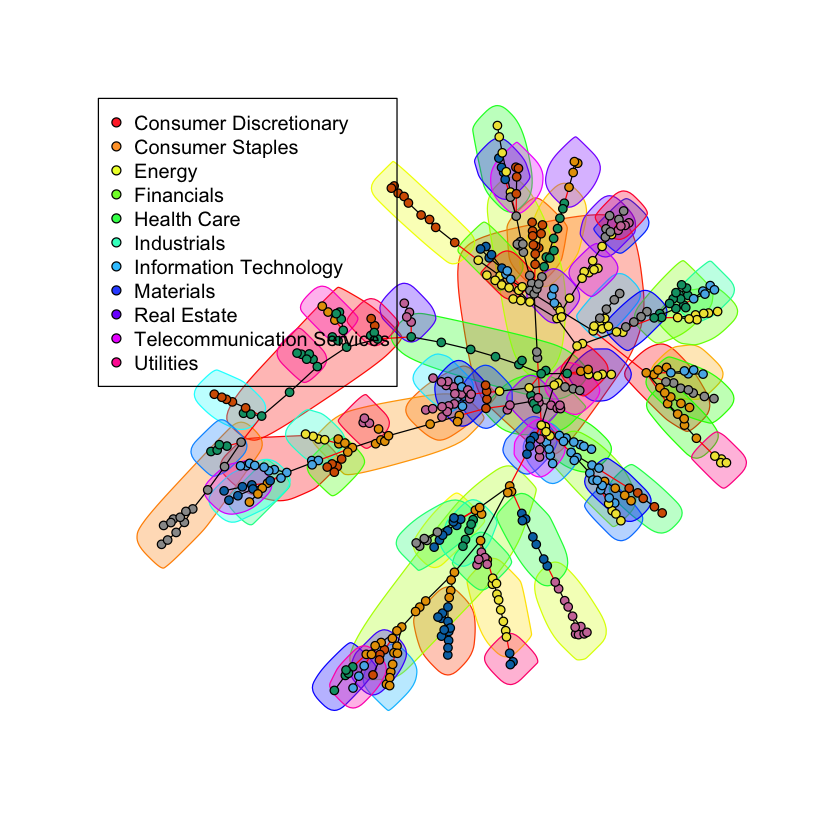

In [294]:
# Clustering of correlation graph
wc_monthly <- walktrap.community(mst_gm, weights= E(mst_gm)$weights, modularity = TRUE) 
length(wc_monthly)
plot(wc_monthly, mst_gm, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [295]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)
pred <- c(wc_monthly$membership)
homogeneity(true, pred)
completeness(true,pred)

[1] 0.5095092

[1] 0.2823379

In [296]:
card_V = length(V(mst_gm))
sum1 = 0
sum2 = 0
for(v in V(mst_gm)){
    card_N = length(neighbors(mst_gm,v))
    v_sect = sectors.index[v]
    card_Q = 0
    for(n in neighbors(mst_gm, v)){
        if(sectors.index[n] == v_sect){
            card_Q = card_Q + 1
        }
    }
    card_S = length(sectors.index[sectors.index==v_sect])
    p1 = card_Q / card_N
    p2 = card_S / card_V
    sum1 = sum1 + p1
    sum2 = sum2 + p2
}
alpha1 = sum1 / card_V
alpha2 = sum2 / card_V
print("Alpha with first definition of P:")
print(alpha1)
print("Alpha with second definition of P:")
print(alpha2)

[1] "Alpha with first definition of P:"
[1] 0.4834683
[1] "Alpha with second definition of P:"
[1] 0.1141881


QUESTION 8: Compare and analyze all the results of daily data vs weekly data vs monthly data. What trends do you find? What changes? What remains similar? Give reason for your observations. Which granularity gives the best results when predicting the sector of an unknown stock and why?

Interval|Homogeneity|Completeness|P1 Definition $\alpha$|P2 Definition $\alpha$  
---|---|---|---|---
Daily|0.682644648161366|0.479284479244588|0.8289301|0.1141881
Weekly|0.58200695320238|0.390771399621547|0.7429696|0.1141881
Monthly|0.509509234436883|0.282337925983778|0.4834683|0.1141881

As the time interval increases, the homogeneity and completeness decrease. This indicates that the smallest granularity, Daily, gives the best results when predicting the sector of an unkown stock. This is because the minimum spanning tree is better at grouping together the sectors when the time interval is small as can be seen in the MST graphs. That is, as the time span increases from daily to monthly, the sectors are more dispersed in the vine clusters. The P1 definition for $\alpha$ also decreases as the interval decreases. This makes sense due to P1 being defined as the fraction of neighbors being in the same sector over the total neighbors for a given node. If the sectors are grouped together, this fraction will be high for more nodes which contributes to a higher $\alpha$ overall. The p2 definition remains constant for all of the time intervals. This is due to the fact that P2 is defined as the fraction of all nodes belonging to a sector over all nodes. The sum adds a term for a given sector for each node that belongs to that sector. Since the number of nodes remains constant and their sector membership remains constant, this fraction and $\alpha$ will also remain constant.